### Import libraries

In [1]:
import os
import sys
sys.path.append("..")
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np

In [2]:
# options: rbf, periodic
print('Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
d = True if kernel.split('_')[-1] == '2D' else False
save_dir = os.path.expanduser('~/Downloads/GPT_' + kernel)

Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D
rbf_const_2D
How many observations? (deafult 150000)
1
Do you want to overwrite data? True/False
False


In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = False, d = d, ordered = True)

['em_te_2.npy', 'pad_pos_tr.npy', 'pad_pos_te.npy', 'em_te.npy', 'em_tr.npy', 'pad_y_fren_tr.npy', 'pad_y_fren_te.npy', 'em_tr_2.npy']


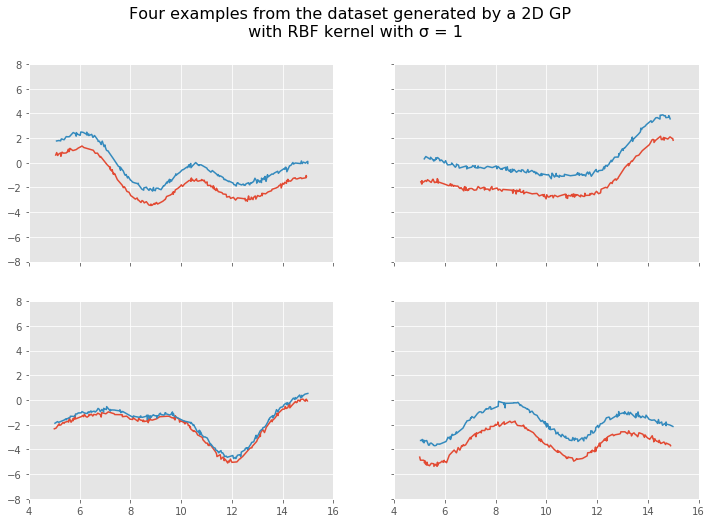

In [4]:
if d:
    plotter.plot_2d_examples(data[2], data[-2], data[0])
else:
    plotter.plot_examples(data[0], data[4])

In [5]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [6]:
# batch_x_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_x_tr, pad_y_fren_tr, batch_s=1)

In [ ]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 103; step = 0; train_steps = 35000; heads = 1; ℯ = 256; context = 10
    l = [256, 256, 64, 32]
    name_comp = 'run_' + str(run) 
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp
#     lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(3e-4)
    ℯ, l1, _, l2, l3 = helpers.load_spec(folder, ℯ, l, context,  d = d)
    helpers.mkdir(folder)
    if d:
        decoder = experimental2d_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    else:
        decoder = experimental_model.Decoder(ℯ, l1, l2, l3, num_heads = heads)
    tf.random.set_seed(443)  
    num_batches = int(data[5].shape[0] / batch_s) if d else int(data[4].shape[0] / batch_s)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(3e-4)
    with writer.as_default():
        for epoch in range(EPOCHS):
            
            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
#                     b_data = batch_creator.create_batch(em_x = data[-4], x = data[1], y = data[-3],  em_2 = data[-1], batch_s=64, d=d)
                    b_data, c = batch_creator.create_batch_2d(em_x = data[-4], x = data[1], y = data[-3],  em_2 = data[-1], batch_s=64)
#                     print('c: ', c)
                    if type(c) is list:
                        cols = [np.arange(c[i], b_data[2].shape[1] -1, 1) for i in range(len(c))]
                        cc = np.concatenate(cols, axis=0 )
                        rows = [np.repeat(i, len(m)) for i, m in enumerate(cols)]
                        r = np.concatenate(rows, axis=0)
                        to_gather = np.concatenate((r.reshape(-1, 1), cc.reshape(-1,1)), 1)
                    else:
                        to_gather = None
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=to_gather, context_p = c)
#                     pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=None, context_p = context)
                else:
                    b_data = batch_creator.create_batch(em_x = data[3], x = data[0], y = data[4], batch_s=64, d=d)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], context_p = context)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        b_data_te, c_te = batch_creator.create_batch_2d(em_x = data[3], x = data[2], y = data[6],  em_2 =  data[0], batch_s=64)
                        if type(c_te) is list:
                            cols = [np.arange(c_te[i], b_data_te[2].shape[1] -1, 1) for i in range(len(c_te))]
                            cc = np.concatenate(cols, axis=0 )
                            rows = [np.repeat(i, len(m)) for i, m in enumerate(cols)]
                            r = np.concatenate(rows, axis=0)
                            to_gather_te = np.concatenate((r.reshape(-1, 1), cc.reshape(-1,1)), 1)
                        else:
                            to_gather_te = None
                        
                        
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=to_gather_te, context_p = context, d=True)
                        
                        
                        
#                         plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = data[2][:500], y_te = data[-2][:500], em_2_te = data[0][:500] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = data[2][:500, :], y_te = data[5][:500, :], context_p = context)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = data[1][:500, :], y_te = data[5][:500, :], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
#                     if d:
#                         m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
#                         m0_te, m1_te = metrics.r_sq_2d(data[-2][:500, 1:], pred_te.numpy(), data[0][:500, 1:], context_p = context)
#                         print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
#                         print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))

#                     else: 
#                         print('r squared training: ', metrics.r_squared(m_tr.result(), b_data[0][:, (context + 1):]))
#                         print('r squared testing: ', metrics.r_squared(m_te.result(), data[5][:500, (context + 1):], batch_s = 500))


                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Does not exists
New folder /Users/omernivron/Downloads/GPT_rbf_const_2D/ckpt/check_run_103
Initializing from scratch.
Tensor("Mean:0", shape=(349,), dtype=float64)
Tensor("Mean:0", shape=(349,), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 0 batch 0 train Loss 2.7254 test Loss 1.8655 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", s

Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 0 batch 300 train Loss 0.5850 test Loss 0.6019 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 0 batch 600 train Loss 0.4294 test Loss 0.4484 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("

Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Epoch 0 batch 900 train Loss 0.3887 test Loss 0.3993 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 0 batch 1200 train Loss 0.4949 test Loss 0.4379 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 0 batch 1500 train Loss 0.4293 test Loss 0.4327 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Epoch 0 batch 1800 train Loss 0.4178 test Loss 0.3978 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Time taken for 1 epoch: 3285.9306008815765 secs

Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 1 batch 0 train Loss 0.3630 test Loss 0.4582 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Epoch 1 batch 300 train Loss 0.3811 test Loss 0.3945 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean:0", shape=(389,), dtype=float64)
Epoch 1 batch 600 train Loss 0.3863 test Loss 0.4178 with training MSE metric 0.0000 and testing MSE metric 0.0000
learning rate is 0.0003000000142492354


Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)
Tensor("Mean_1:0", shape=(), dtype=float64)


In [ ]:

# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(decoder.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(logdir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(logdir, config)

In [8]:
import numpy as np

In [9]:
decoder.A3.get_weights()[0]

array([[-0.00067615,  0.05615514,  0.06738966, ...,  0.07630116,
         0.02603091, -0.02499514],
       [-0.00445037,  0.0739135 ,  0.06490256, ..., -0.05417611,
        -0.042437  ,  0.08646967],
       [ 0.09078338,  0.03334402, -0.02741638, ..., -0.04715771,
         0.09397197, -0.02844256],
       ...,
       [-0.08380008, -0.0730588 , -0.02273733, ..., -0.01772035,
         0.00447622,  0.12148779],
       [ 0.08152599, -0.05984541,  0.00963409, ..., -0.07076796,
         0.02448639, -0.09745528],
       [-0.06458792,  0.0570612 , -0.00406764, ..., -0.00265749,
        -0.09037016, -0.09822507]])

In [20]:
yy

array([-4.26272849, -4.27346638, -2.36653723, -4.53162336, -2.35641413,
       -4.37475341, -2.50723135, -4.45219437, -2.49756181, -4.32522265,
       -4.61328762, -4.36532997, -4.32891009, -4.63035982, -4.54315738,
       -2.51336665, -2.46893865, -4.5141097 , -2.51160964, -2.58959126,
       -4.4633695 , -4.42736883, -4.29982248, -4.23334807, -4.29205375,
       -4.47704544, -4.27588571, -4.08024986, -4.26664544, -3.96599945,
       -4.1736572 , -3.82784993, -3.8989129 , -3.66225503, -3.42245033,
       -3.76607759, -3.55103539, -3.40152678, -3.23213741, -3.23938731,
       -3.29959846, -3.22331198, -3.00017195, -3.090431  , -2.9084842 ,
       -2.79222105, -2.72459927, -2.58822124, -2.66508157, -2.44137795,
       -2.56770165, -2.64611961, -2.58170453, -2.42194352, -2.39036907,
       -2.39628514, -2.58369733, -2.49086923, -2.30620345, -2.36598329,
       -2.2760985 , -2.04352515, -2.13163929, -2.08645348, -1.99397639,
       -2.08725714, -1.96688552, -2.00548858, -1.93929814, -1.88

In [30]:
idx

12351

In [33]:
s_y_inf

array([0.21882485, 0.23104813, 0.44991313, 0.29905875, 0.75180616,
       0.46319674, 0.69545277, 0.72355076, 0.62454857, 0.58641633,
       0.65176444, 0.81410831, 0.65402666, 0.76162372, 0.80111789,
       0.84155006, 0.83189343, 0.81980638, 0.75764435, 1.09993662,
       1.09199353, 1.04999057, 0.97334607, 1.27070966, 1.04906391,
       1.1018194 , 1.0591464 , 1.03579657, 1.34480692, 1.19746136,
       1.28430191, 1.29878533, 1.26550061, 1.25232163, 1.19276993,
       1.43333392, 1.36232185, 0.98660137, 1.23689858, 0.94586882,
       1.27181383, 1.12708471, 1.09999628, 1.12533559, 1.28329849,
       1.25016936, 1.10363771, 1.09034993, 0.17339208, 0.23244851])

In [37]:
xx[247]

14.929823735131858

In [38]:
em

array([[1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [43]:
x_t = data[2][idx, :]

In [45]:
y_t = data[6][idx, :]

In [47]:
em_t = data[3][idx, :]

In [49]:
em2_t = data[0][idx, :]

In [53]:
x_t[np.where(x_t == 7.385577445634535)[0]]

array([7.38557745])

In [54]:
y_t[309]

0.9127748803217954

In [55]:
em_t[309]

264.0

In [56]:
em2_t[309]

0.0

In [58]:
decoder.embedding(0)

<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([ 0.00034281, -0.05660817, -0.00242884,  0.02826494,  0.05410074,
        0.00902021,  0.03740817,  0.00669687,  0.03200907,  0.0334577 ,
        0.01902916,  0.03769331,  0.06629961,  0.05626754, -0.05191311,
        0.02305878,  0.0483908 ,  0.03543012, -0.05480604, -0.01493656,
       -0.06614347,  0.05128532, -0.02511129, -0.00556938,  0.03826302,
        0.01991776,  0.01459734,  0.00739122, -0.02267411,  0.0175861 ,
        0.01330454,  0.00324987, -0.06697834, -0.05136501, -0.0184265 ,
        0.03932506, -0.01544611,  0.00084507,  0.04391793,  0.04779572,
        0.03838504,  0.00909136,  0.0054286 , -0.03871324,  0.02651691,
       -0.01703326,  0.05934025, -0.03525568,  0.04391223,  0.02788468,
       -0.05718574,  0.04728326, -0.031332  , -0.03035568, -0.03388605,
        0.00211812,  0.0342325 , -0.06528154,  0.04696693, -0.02660087,
       -0.01220594,  0.05658798,  0.02789567,  0.00084951, -0.00831896,
        0.006662

In [57]:
decoder.embedding(264)

<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([ 0.01192533,  0.01743802,  0.0863186 , -0.04189705, -0.02271961,
        0.09682556, -0.07458587,  0.02941507, -0.0498574 , -0.04340535,
        0.08827094, -0.07793977,  0.07641014,  0.04222118,  0.04100723,
        0.00401398, -0.01330148,  0.00659937, -0.04067785, -0.01517294,
        0.09677176, -0.11208441, -0.0753881 , -0.02146526, -0.05302359,
       -0.07007252, -0.06001698,  0.0111846 ,  0.04718316, -0.02906682,
        0.01939971,  0.01288024,  0.02676155,  0.09857946, -0.07444574,
       -0.03304614,  0.04925435, -0.11313834,  0.10054532,  0.00142329,
       -0.10085777, -0.05341978,  0.01787975,  0.07927943,  0.03281651,
       -0.03178224, -0.08530949,  0.02617413,  0.08353607,  0.02272361,
       -0.0083225 , -0.01679901,  0.06461325, -0.07171301, -0.10612646,
        0.06809324,  0.00089103, -0.09021849, -0.02112054, -0.03513806,
        0.03993411, -0.04868795,  0.02580609, -0.02196348,  0.00263379,
       -0.047249

In [65]:
np.where(em2_t == 1)[0]

array([  0,   1,   2,   5,   9,  10,  11,  13,  14,  16,  17,  19,  20,
        22,  23,  25,  26,  28,  29,  31,  37,  39,  40,  41,  42,  44,
        45,  55,  56,  59,  60,  61,  62,  63,  65,  67,  68,  70,  73,
        75,  79,  80,  83,  84,  86,  89,  90,  92,  93,  96,  98,  99,
       104, 105, 110, 112, 116, 120, 126, 131, 132, 133, 134, 136, 137,
       138, 140, 141, 142, 147, 148, 151, 152, 154, 155, 161, 166, 168,
       169, 172, 175, 176, 177, 179, 180, 182, 184, 185, 188, 189, 190,
       192, 194, 195, 200, 202, 209, 213, 214, 215, 216, 220, 221, 224,
       227, 229, 230, 231, 232, 233, 235, 237, 244, 247, 248, 249, 251,
       252, 253, 255, 256, 258, 259, 260, 261, 263, 266, 268, 269, 270,
       272, 274, 276, 279, 280, 281, 284, 285, 288, 290, 291, 293, 297,
       298, 299, 301, 304, 305, 307, 312, 313, 314, 315, 316, 317, 318,
       319, 324, 326, 327, 328, 329, 330, 331, 334, 336, 337, 338, 339,
       340, 343, 344, 345, 346, 347, 350, 351, 353, 354, 362, 36

In [96]:
idxs_0 = np.argsort(x_t[np.where(em2_t == 0)])
idxs_1 = np.argsort(x_t[np.where(em2_t == 1)])

In [97]:
y_u0 = y_t[np.where(em2_t == 0)][idxs_0[:25]]
y_u1 = y_t[np.where(em2_t == 1)][idxs_1]

In [98]:
V = np.concatenate((y_u0, y_u1))

In [105]:
x_u0 = x_t[np.where(em2_t == 0)][idxs_0[:25]]
x_u1 = x_t[np.where(em2_t == 1)][idxs_1]
U = np.concatenate((np.concatenate((x_u0, x_u1)), x_t[np.where(em2_t == 0)][idxs_0[25]].reshape(-1)))

In [106]:
em_0 = em_t[np.where(em2_t == 0)][idxs_0[:25]]
em_1 = em_t[np.where(em2_t == 1)][idxs_1]  
Z = np.concatenate((np.concatenate((em_0, em_1)) , em_t[np.where(em2_t == 0)][idxs_0[25].reshape(-1)]))

In [107]:
em2_0 = em2_t[np.where(em2_t == 0)][idxs_0[:25]]
em2_1 = em2_t[np.where(em2_t == 1)][idxs_1]  
W = np.concatenate((np.concatenate((em2_0, em2_1)), em2_t[np.where(em2_t == 0)][idxs_0[25].reshape(-1)])) 

In [66]:
x_t[np.where(em2_t == 0)][:25]

array([ 6.40276171, 11.2091354 ,  7.32541093, 10.13859222,  9.3984167 ,
       14.17018054, 12.29557406,  8.80673852, 11.08067217, 12.99657135,
        9.27034108,  8.06254764,  5.55736066,  5.79623052,  7.14481779,
       14.72596074, 12.3471238 , 10.06666061, 13.63365906, 10.80697958,
        8.31768639, 13.19262565, 11.21540451,  6.09239009, 10.64655188])

In [59]:
x_t[np.where(em2_t == 1)]

array([11.97448839, 13.51554307,  6.64584863, 12.8632784 , 12.17619636,
       11.07176118, 11.86308229,  6.26714756, 10.6347308 , 12.03926348,
        7.16035335,  6.49112616, 12.50313112, 12.58049895,  7.71355084,
        7.34975178, 13.37818101, 13.33818234,  8.91190302,  6.35255468,
       14.76122927,  6.5349862 ,  9.16258564, 10.08732038, 14.21046182,
       12.3505882 ,  8.42987183,  9.09780619, 13.83540274, 12.85445763,
       14.16282647,  9.59994671,  5.19513608,  8.01664238, 11.07472245,
        5.54201922,  8.50381612,  7.54257939, 11.26437054,  8.03024137,
        7.04899821,  5.41161016, 14.41476353,  5.74308185,  5.20045931,
        5.04558136,  5.67932295, 10.66093769, 11.01533791, 13.58482037,
       11.1756601 ,  9.21631118, 12.17835814,  9.13093839,  9.96365818,
       11.30267327, 12.21220075,  8.89316684,  6.67831734,  8.56301561,
        8.47479105, 10.25926885, 10.18723339, 11.61175834, 11.77457002,
        6.70910712,  8.02924787,  5.4469129 , 14.33410495,  7.96

In [11]:
from inference import infer

In [12]:
from helpers import masks

In [154]:
combined_mask_x = masks.create_masks(U.reshape(1, -1))

In [161]:
combined_mask_x[:, :-1, :-1]

<tf.Tensor: shape=(1, 225, 225), dtype=float32, numpy=
array([[[0., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [163]:
x1 = decoder.embedding(Z.reshape(1, -1))

In [164]:
x2 = decoder.embedding(W.reshape(1, -1))

In [170]:
y_attn, _  = decoder.mha(V.reshape(1, -1)[:, :, tf.newaxis], x1, x1, x2, combined_mask_x[:, :-1, :-1])

(1, 32, 226, 16)


In [171]:
y_attn

<tf.Tensor: shape=(1, 225, 512), dtype=float64, numpy=
array([[[ 0.06684196, -0.0175858 ,  0.0537646 , ..., -0.03475624,
         -0.06539761, -0.04954356],
        [ 0.06695401, -0.01764346,  0.05541872, ..., -0.0345993 ,
         -0.06622512, -0.04957734],
        [ 0.07119502, -0.01508529,  0.07385991, ..., -0.03307079,
         -0.07628724, -0.05089776],
        ...,
        [ 0.000911  , -0.02196733, -0.45437846, ..., -0.07609109,
         -0.09949089, -0.04035562],
        [-0.01241415, -0.02352295, -0.43545863, ..., -0.07783512,
         -0.10856189, -0.04134541],
        [-0.08311059, -0.06662389, -0.2151621 , ..., -0.04839985,
         -0.21488096, -0.14596102]]])>

In [174]:
L = decoder.A1(y_attn) + decoder.A2(x1[:, 1:, :]) + decoder.A3(x2[:, 1:, :])

In [175]:
L = tf.nn.leaky_relu(L)

In [176]:
L = tf.nn.leaky_relu(decoder.A4(L))
L = tf.nn.leaky_relu(decoder.A5(L))
L = decoder.A6(L)

In [177]:
L

<tf.Tensor: shape=(1, 225, 2), dtype=float64, numpy=
array([[[ 0.51181892, -0.09846683],
        [ 0.52861184, -0.1007994 ],
        [ 0.72817484, -0.08698248],
        [ 0.68511592, -0.07966312],
        [ 0.77456762, -0.0722392 ],
        [ 0.79957121, -0.06985481],
        [ 0.9217431 , -0.05593583],
        [ 0.97288657, -0.05234879],
        [ 0.99963979, -0.04571964],
        [ 1.00864135, -0.04502002],
        [ 1.02729299, -0.04423512],
        [ 1.07010294, -0.04311617],
        [ 1.07683136, -0.0430421 ],
        [ 1.09312575, -0.04278072],
        [ 1.10630135, -0.03585394],
        [ 1.15028151, -0.03480221],
        [ 1.19287525, -0.03454903],
        [ 1.20918636, -0.03362926],
        [ 1.27121551, -0.0451949 ],
        [ 1.3021533 , -0.04523772],
        [ 1.34634636, -0.04456935],
        [ 1.4191464 , -0.02461108],
        [ 1.44058397, -0.02309089],
        [ 1.49185142, -0.02111999],
        [ 0.87641943, -0.12461714],
        [ 0.38380692, -0.18529715],
        [-0

In [162]:
decoder(Z.reshape(1, -1), W.reshape(1, -1), V.reshape(1, -1), False, combined_mask_x[:, :-1, :-1]).numpy()[-1]

(1, 32, 226, 16)


array([-0.07940898, -0.1296561 ])

In [159]:
y_t[np.where(em2_t == 0)][idxs_0[25]]

1.1018194048479326

In [83]:
n_s_x0[0]

5.164651117440667

In [84]:
n_s_y0[0]

0.2188248548419628

current step:  246
current_position to infer:  7.153771919892437
current target:  -1.557459454685095
series:  [0.]
current step:  247
current_position to infer:  7.235421285298548
current target:  -1.6316494908495132
series:  [0.]

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

current step:  248
current_position to infer:  7.362862798106554
current target:  -1.7291229095902414
series:  [0.]
current step:  249
current_position to infer:  7.405768336749
current target:  -1.6776948824311797
series:  [0.]
current step:  250
current_position to infer:  7

../model/dot_prod_attention.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(n)


current step:  267
current_position to infer:  8.84042882567729
current target:  -1.2419199783259511
series:  [0.]
current step:  268
current_position to infer:  8.931278174293094
current target:  -1.1813972589194954
series:  [0.]
current step:  269
current_position to infer:  8.962137289684657
current target:  -0.9811434550508478
series:  [0.]
current step:  270
current_position to infer:  8.99636368821114
current target:  -1.0811065620429556
series:  [0.]
current step:  271
current_position to infer:  9.053214273019119
current target:  -0.7827176039745617
series:  [0.]
current step:  272
current_position to infer:  9.071685201577715
current target:  -0.9067631711976991
series:  [0.]
current step:  273
current_position to infer:  9.086590048657968
current target:  -0.7749769730046225
series:  [0.]
current step:  274
current_position to infer:  9.120540523268659
current target:  -0.793459767006459
series:  [0.]
current step:  275
current_position to infer:  9.125438229735234
current ta

current step:  338
current_position to infer:  11.930515631086456
current target:  -0.5033629526845067
series:  [0.]
current step:  339
current_position to infer:  11.952434401504044
current target:  -0.6367076256797889
series:  [0.]
current step:  340
current_position to infer:  12.093020078513138
current target:  -1.187607663619894
series:  [0.]
current step:  341
current_position to infer:  12.143126813004628
current target:  -1.179110757927407
series:  [0.]
current step:  342
current_position to infer:  12.228313720824984
current target:  -1.1908429089208545
series:  [0.]
current step:  343
current_position to infer:  12.294520692016624
current target:  -1.3739811728898543
series:  [0.]
current step:  344
current_position to infer:  12.336686253074468
current target:  -1.6698129391709262
series:  [0.]
current step:  345
current_position to infer:  12.361970800931768
current target:  -1.5251081375854327
series:  [0.]
current step:  346
current_position to infer:  12.37472434853086
c

current step:  284
series:  [0.]
current step:  285
series:  [0.]
current step:  286
series:  [0.]
current step:  287
series:  [0.]
current step:  288
series:  [0.]
current step:  289
series:  [0.]
current step:  290
series:  [0.]
current step:  291
series:  [0.]
current step:  292
series:  [0.]
current step:  293
series:  [0.]
current step:  294
series:  [0.]
current step:  295
series:  [0.]
current step:  296
series:  [0.]
current step:  297
series:  [0.]
current step:  298
series:  [0.]
current step:  299
series:  [0.]
current step:  300
series:  [0.]
current step:  301
series:  [0.]
current step:  302
series:  [0.]
current step:  303
series:  [0.]
current step:  304
series:  [0.]
current step:  305
series:  [0.]
current step:  306
series:  [0.]
current step:  307
series:  [0.]
current step:  308
series:  [0.]
current step:  309
series:  [0.]
current step:  310
series:  [0.]
current step:  311
series:  [0.]
current step:  312
series:  [0.]
current step:  313
series:  [0.]
current st

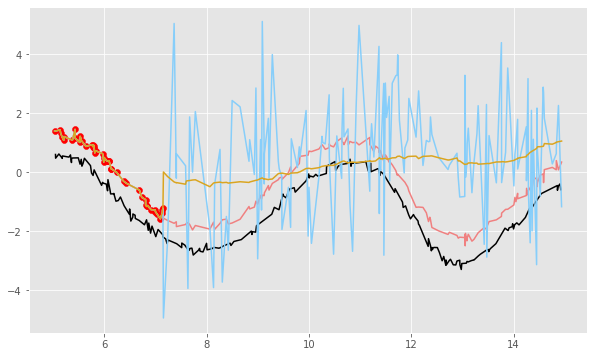

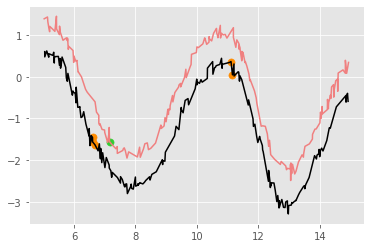

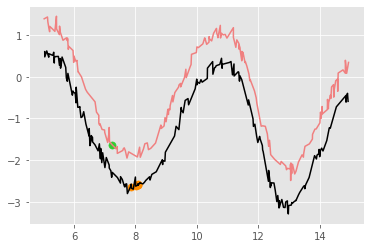

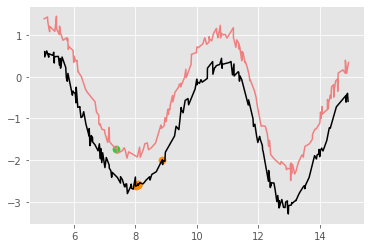

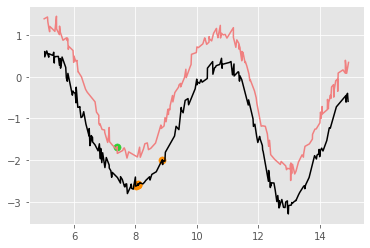

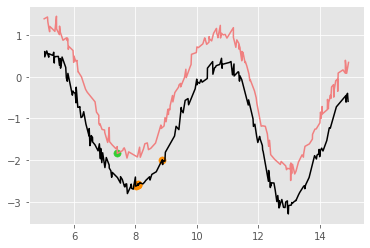

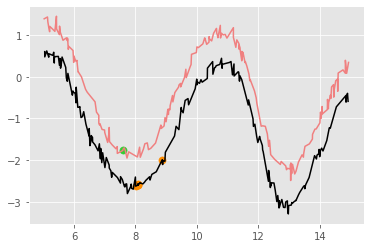

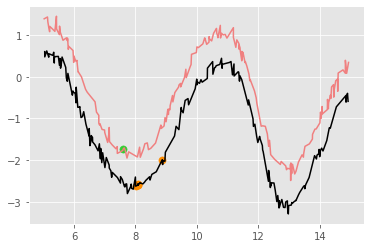

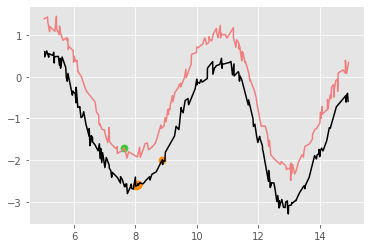

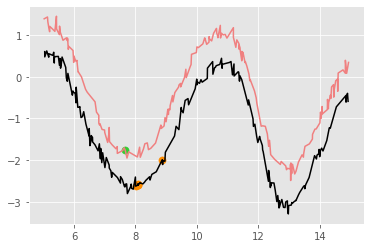

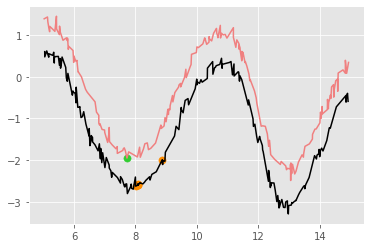

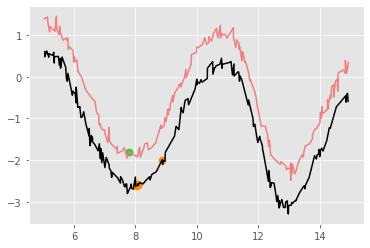

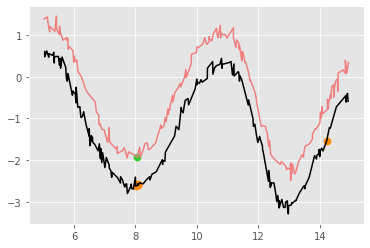

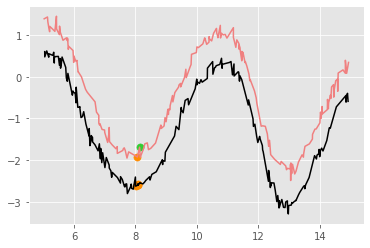

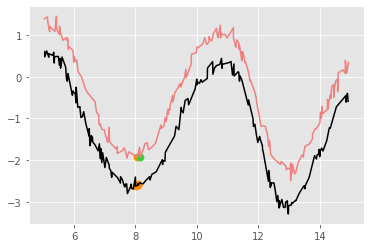

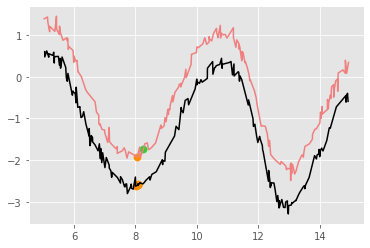

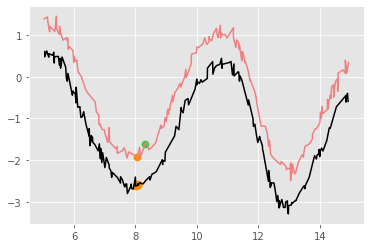

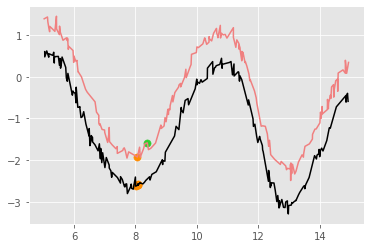

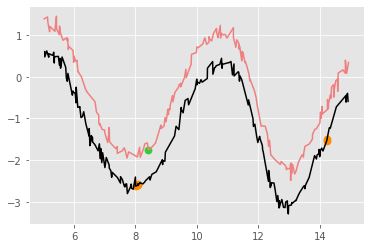

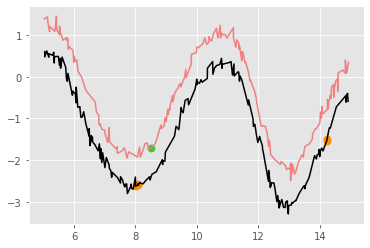

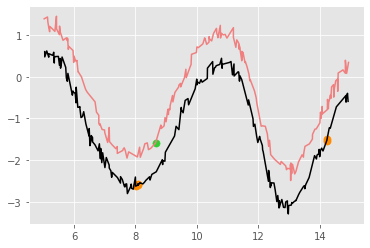

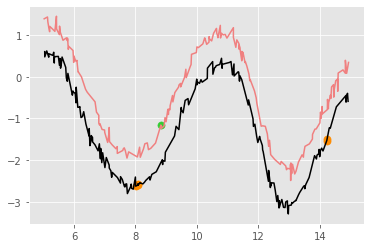

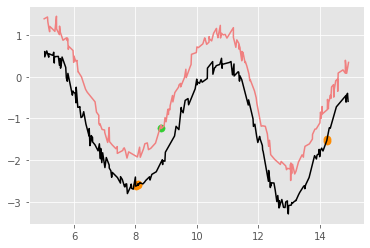

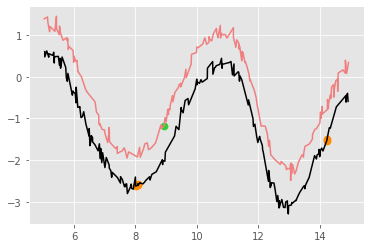

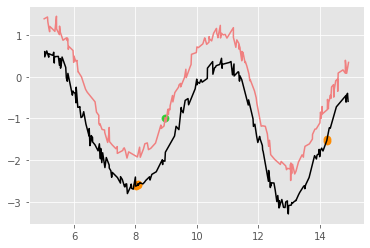

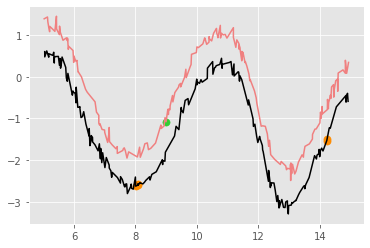

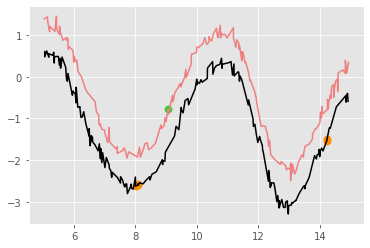

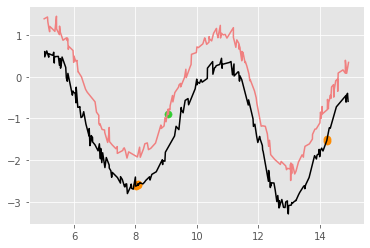

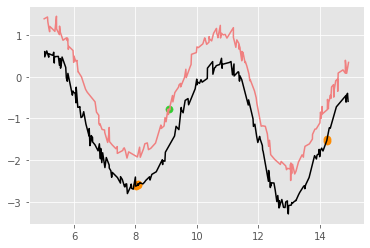

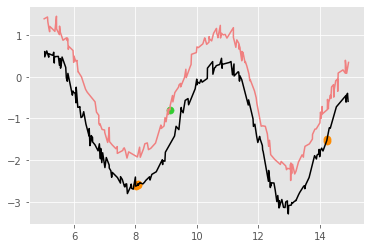

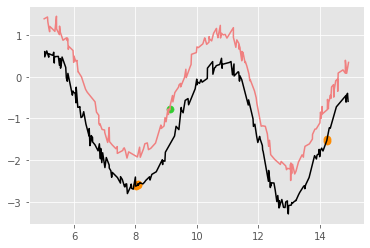

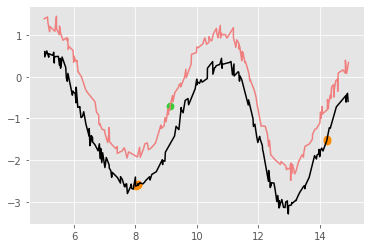

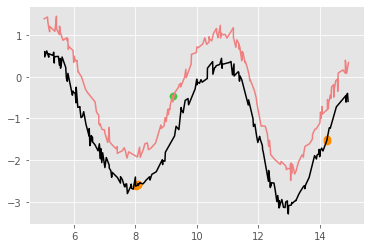

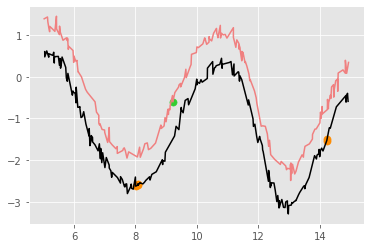

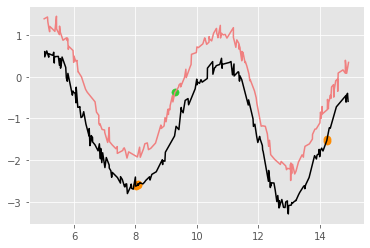

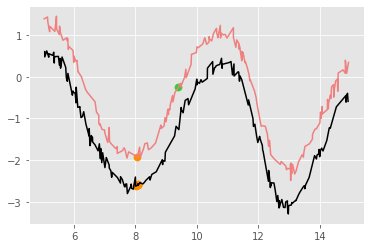

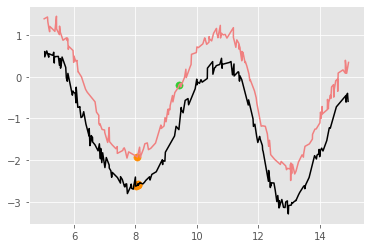

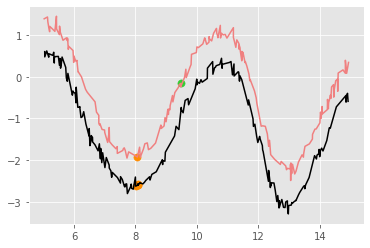

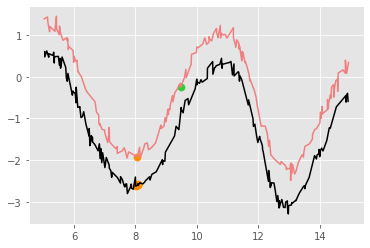

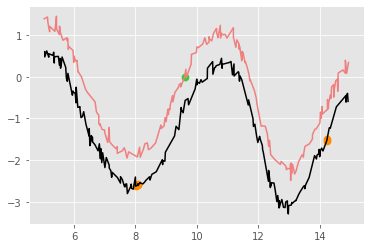

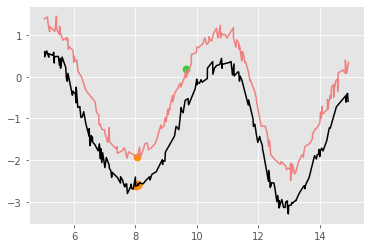

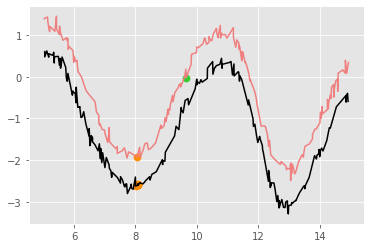

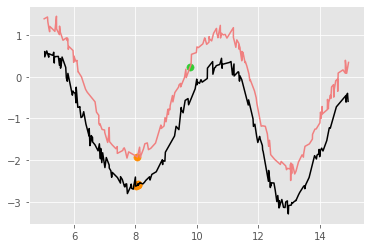

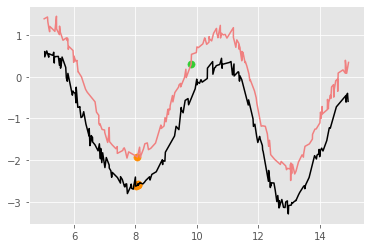

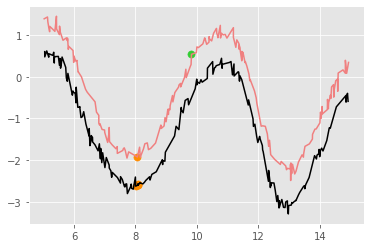

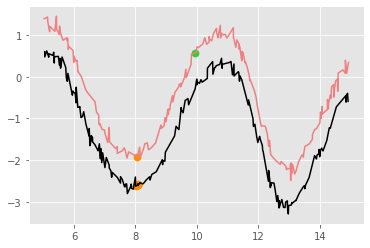

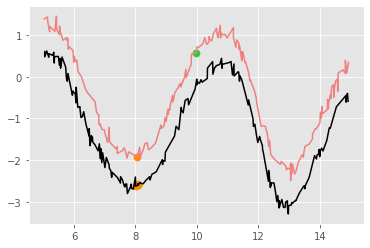

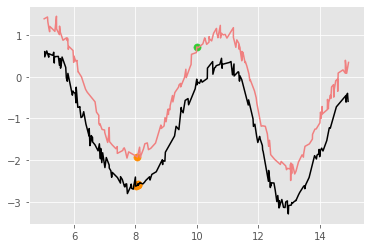

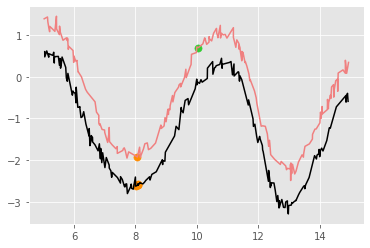

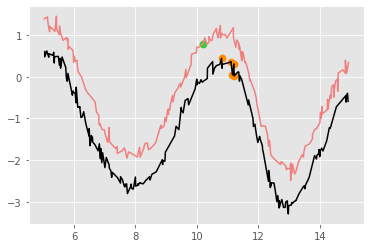

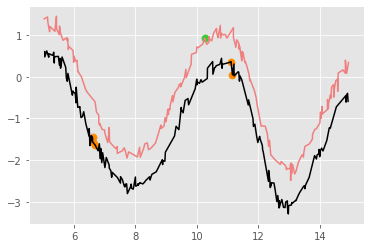

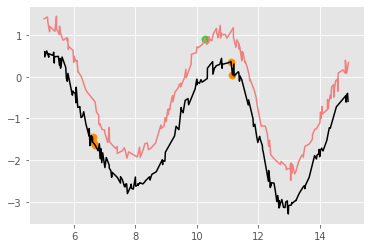

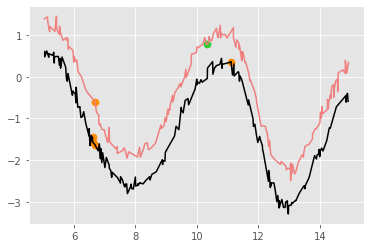

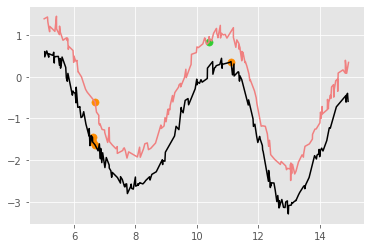

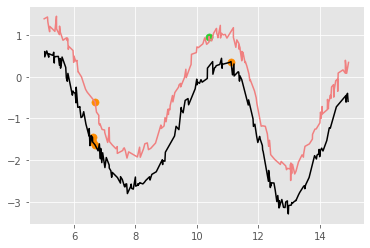

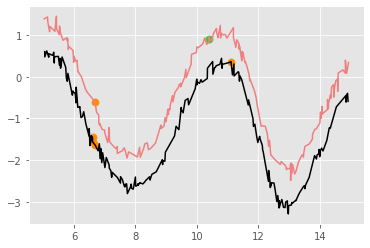

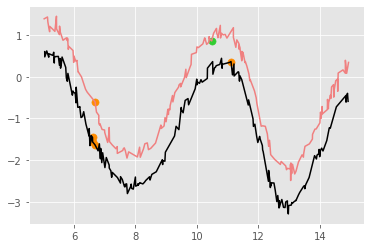

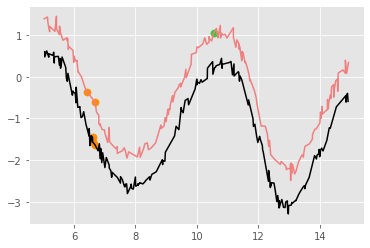

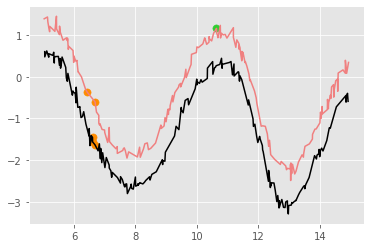

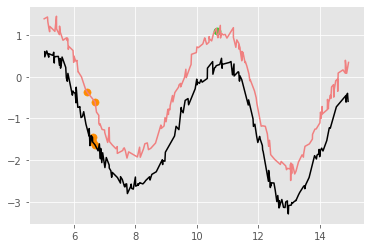

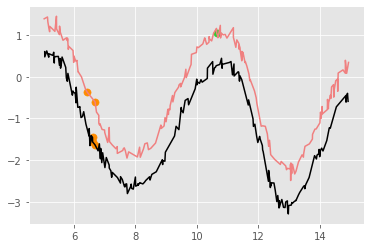

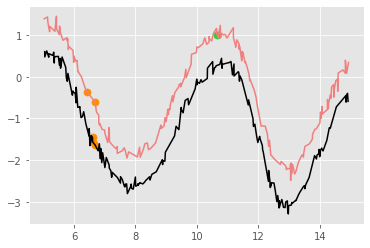

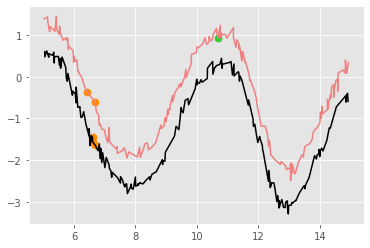

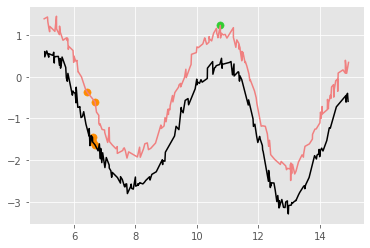

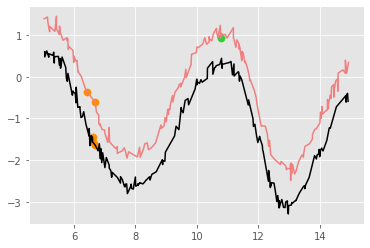

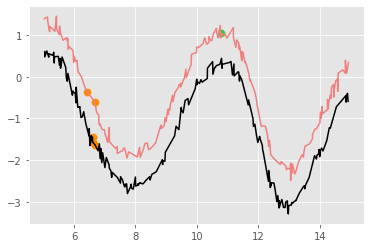

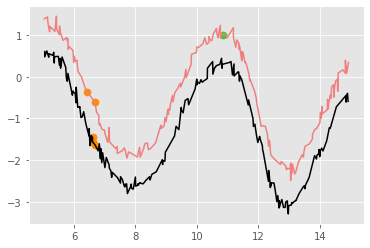

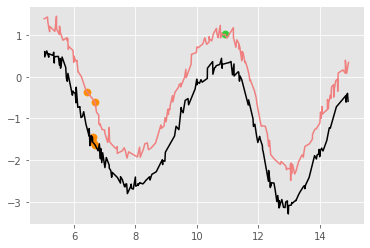

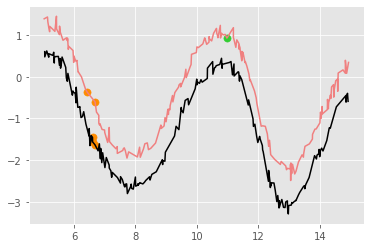

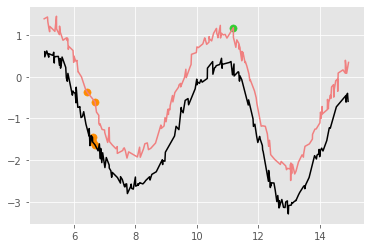

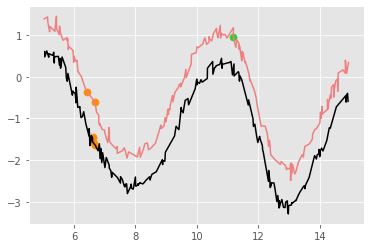

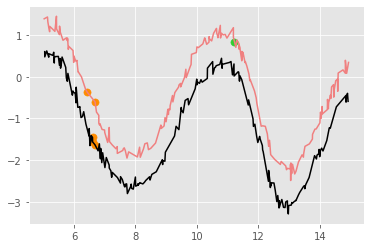

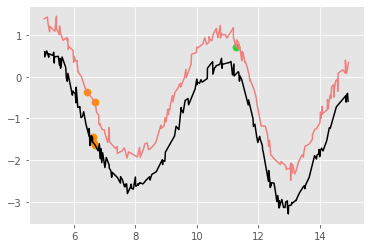

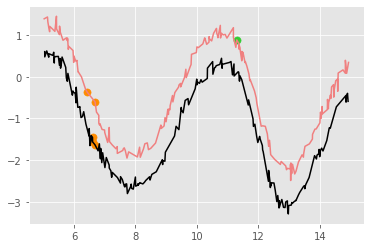

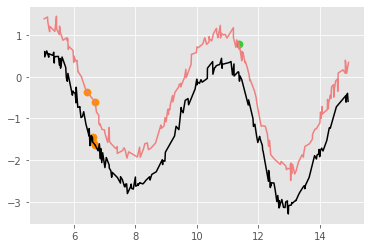

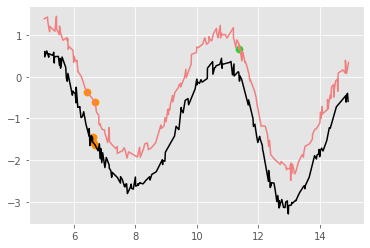

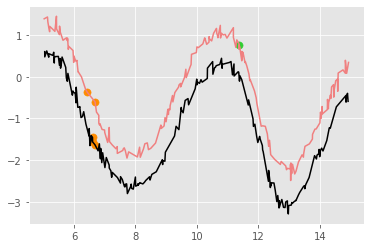

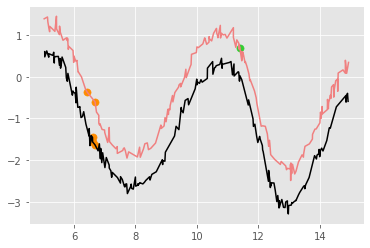

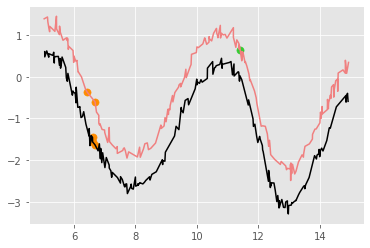

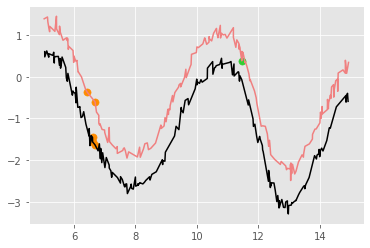

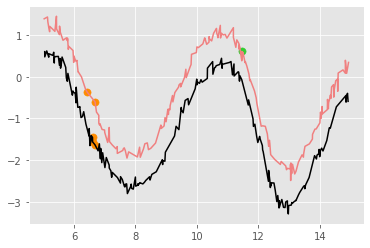

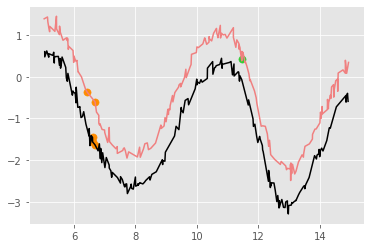

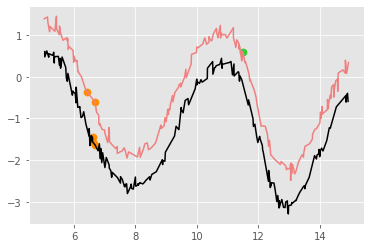

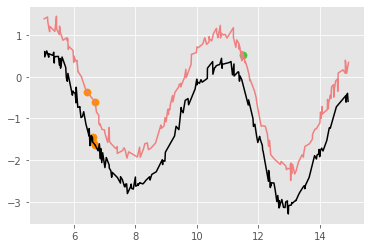

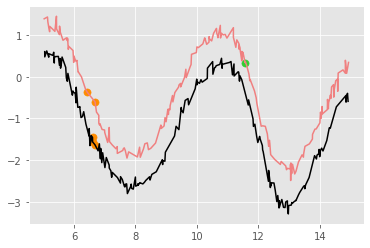

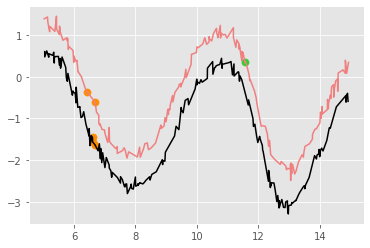

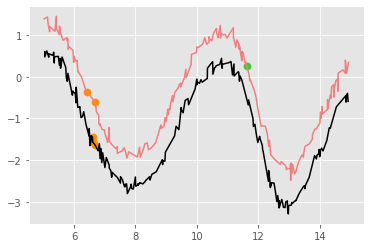

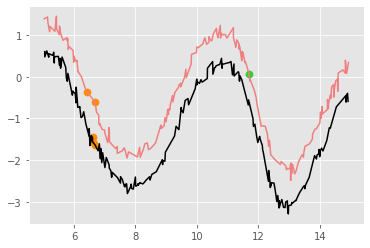

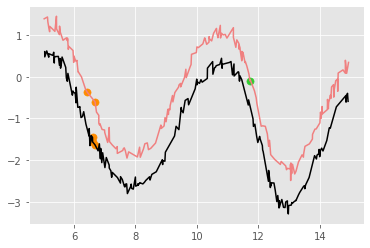

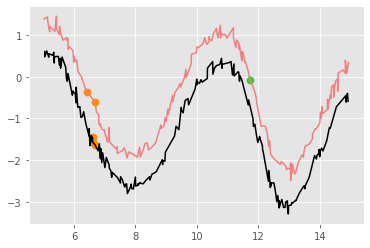

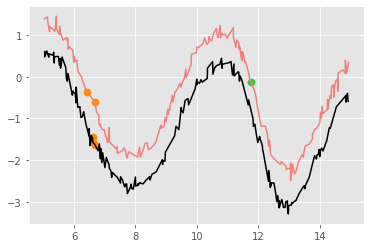

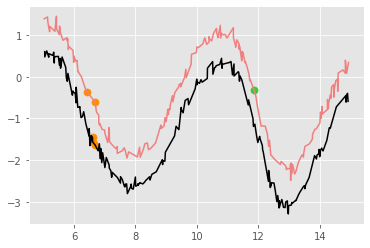

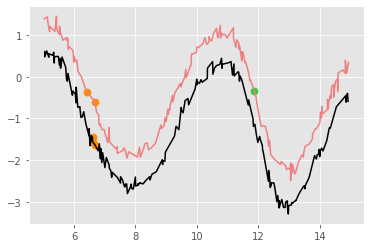

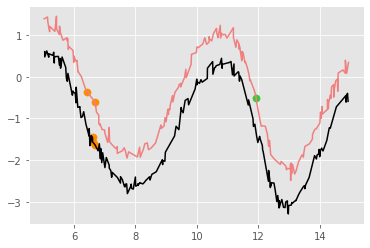

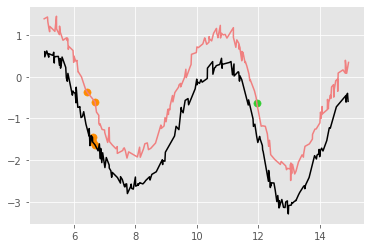

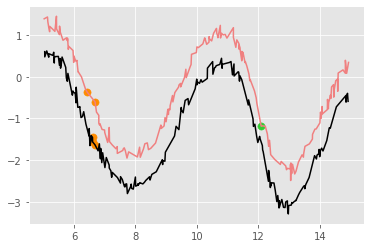

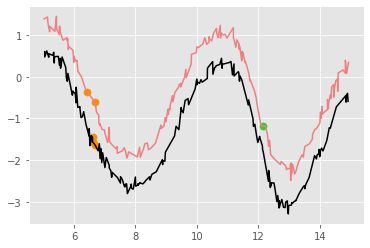

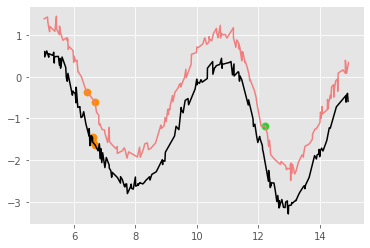

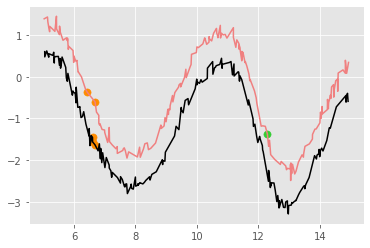

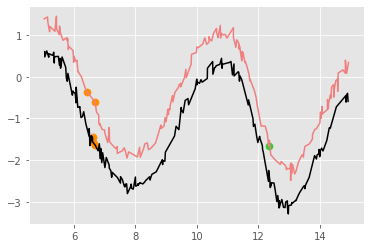

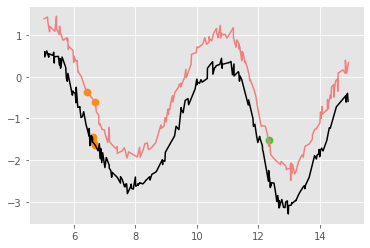

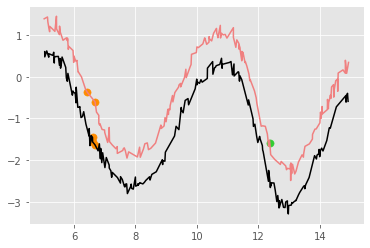

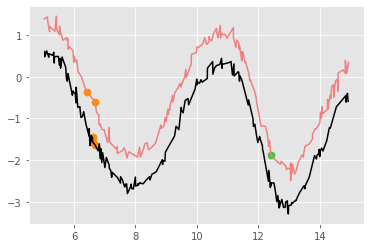

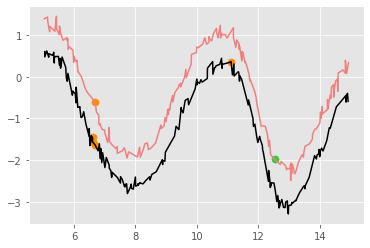

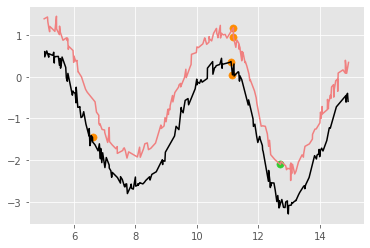

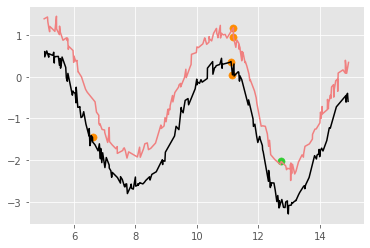

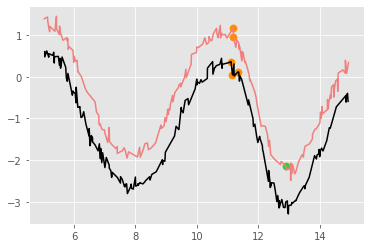

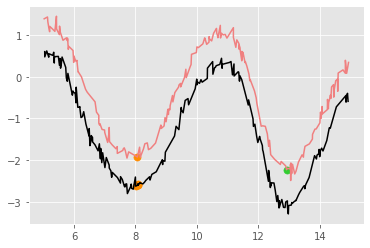

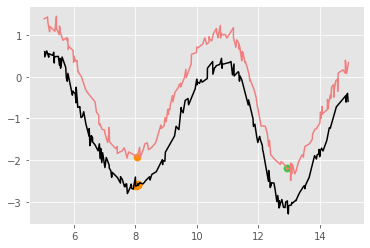

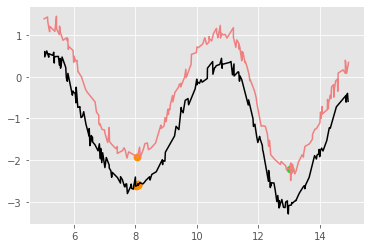

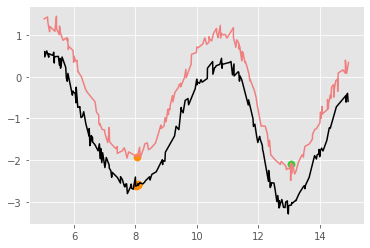

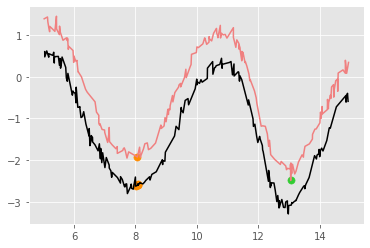

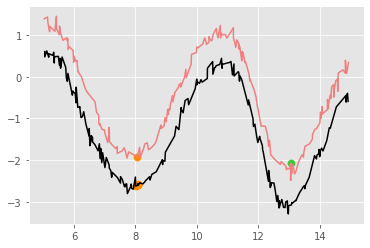

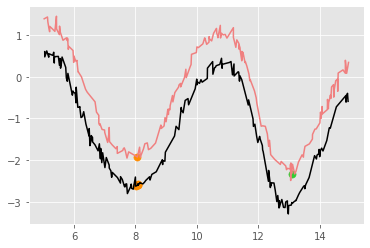

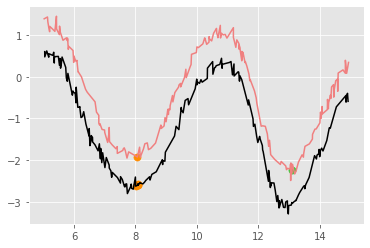

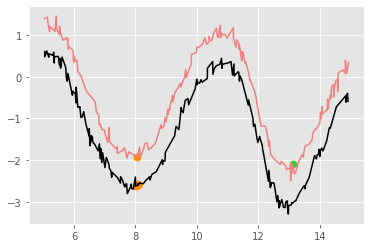

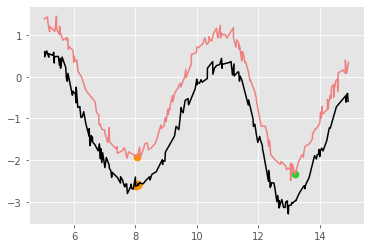

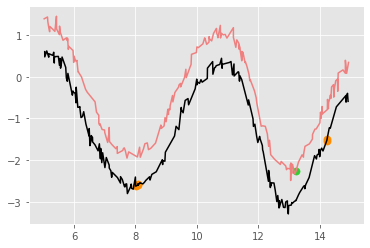

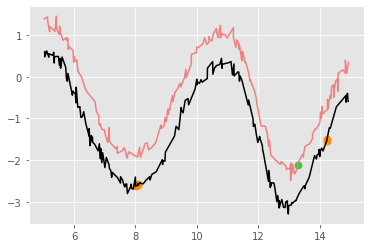

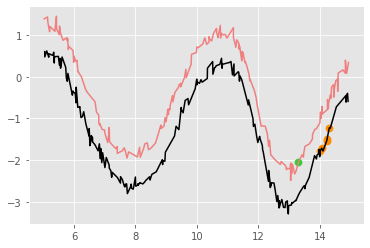

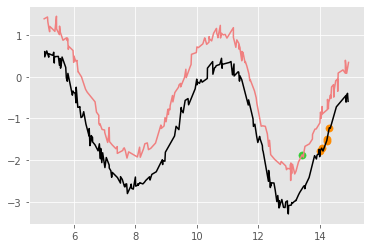

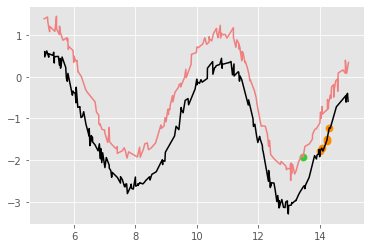

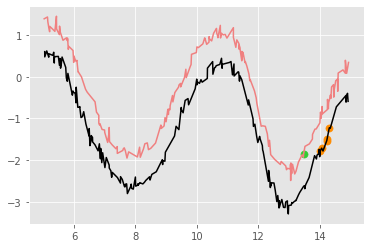

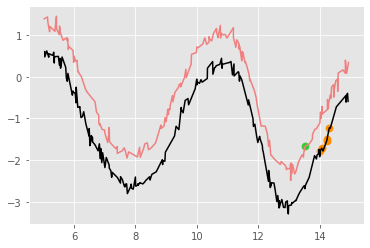

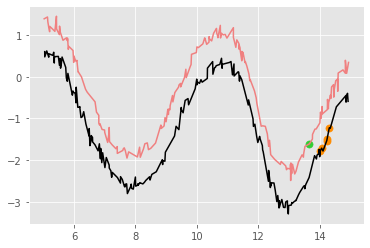

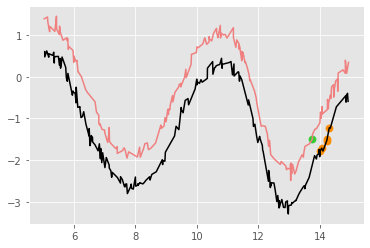

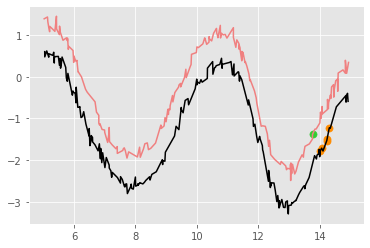

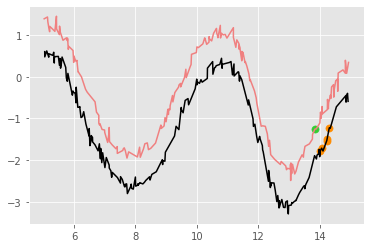

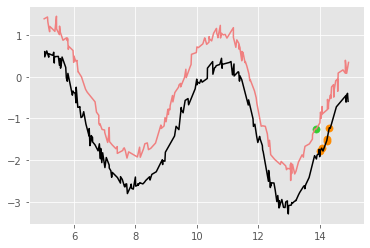

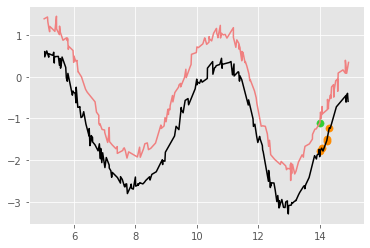

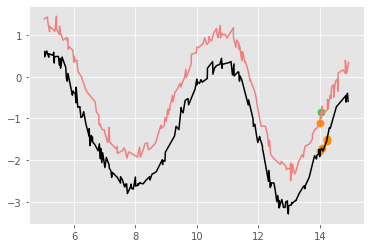

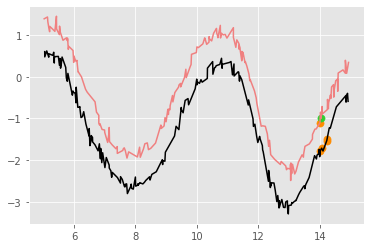

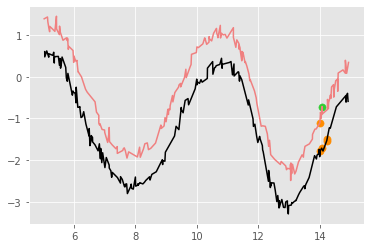

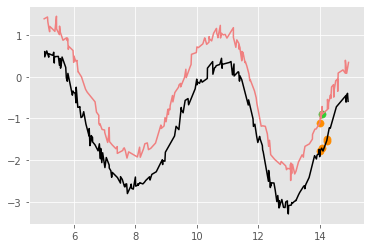

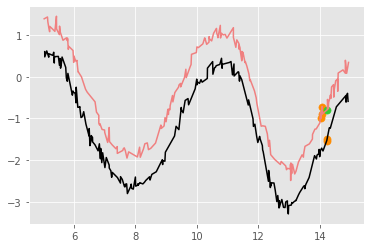

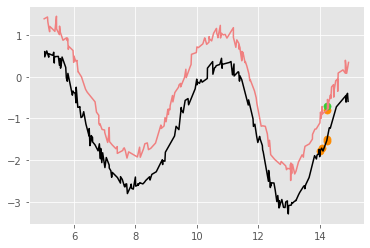

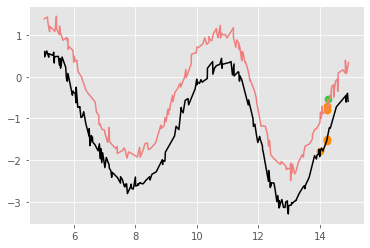

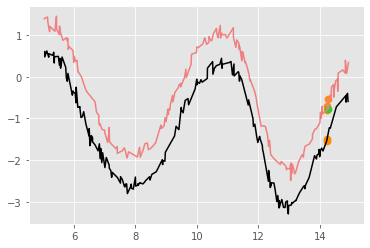

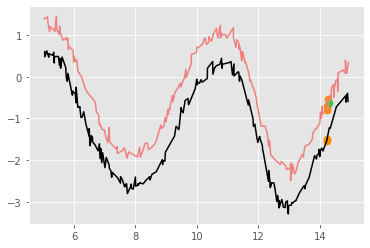

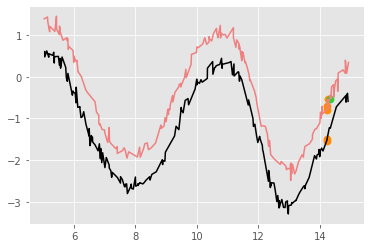

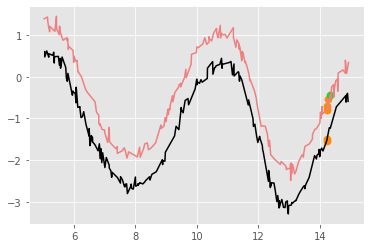

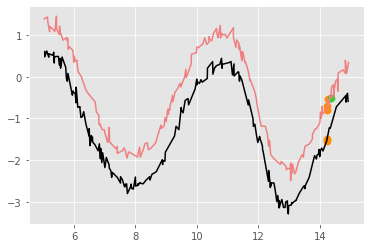

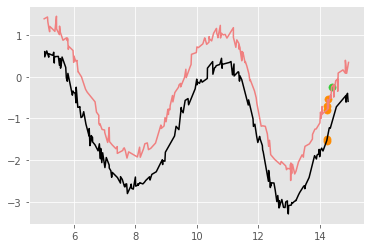

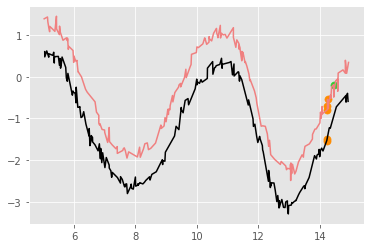

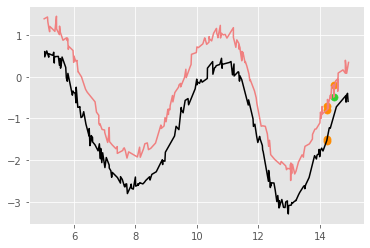

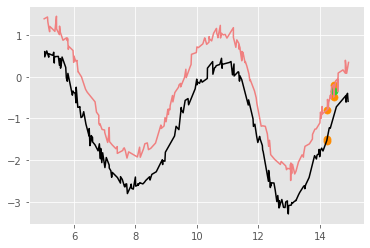

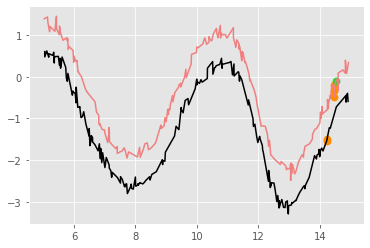

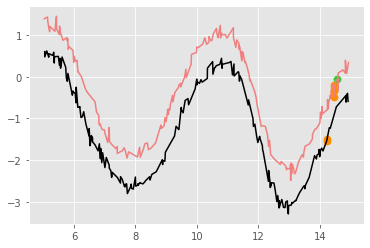

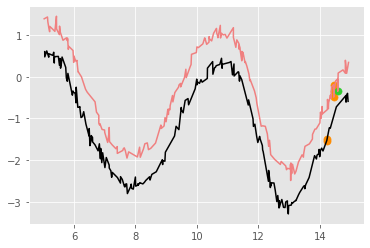

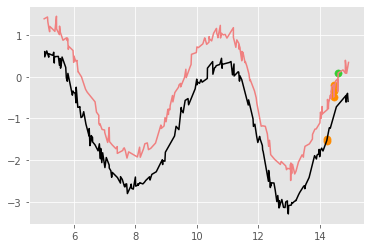

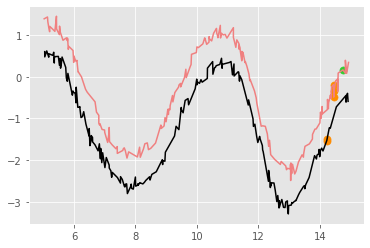

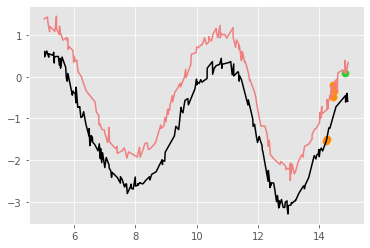

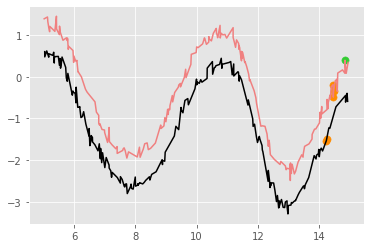

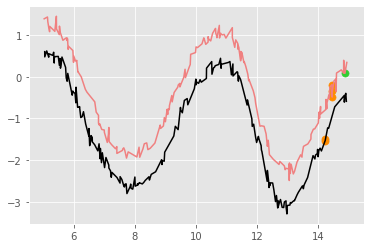

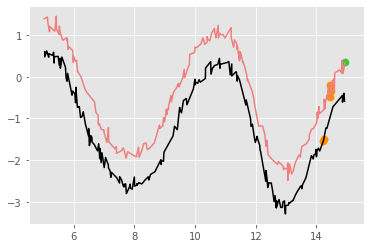

In [8]:

idx = int(np.random.choice(np.arange(0, 30000, 1), 1))
xx, yy, no_s_x1, no_s_y1, x_infer, em, s_y_inf,  n_s_x0_p, n_s_y0_p, n_s_x0, n_s_y0 = plotter.infer_plot2D(decoder, data[2][idx, :], data[6][idx, :], data[3][idx, :], data[0][idx, :], samples = 1, num_steps = 999, consec = True, order = True, context_p = 50)

In [11]:
import glob
from PIL import Image

# filepaths
fp_in = image_folder = '/Users/omernivron/Downloads/attention_plots/*.png'
fp_out = "/Users/omernivron/Downloads/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=700, loop=0)

